# Trajectory Round Trip

This example exercises a significant portion of the classes involved in autonomous pathfinding. The "round trip" consists of:

1. Calculate desired trajectory. This example drives 3 meters down the field over 5.79 seconds and has 133 trajectory points (states).
2. Use trajectory states to calculate swerve module speed and angle for each time period using *inverse kinematics*. A significant parameter is the `Kp` used in correcting the `X` and `Y` velocities, based on the error between the trajectory and odometry field position for each time period.
3. Pass trajectory states to odometry which recreates the path from the swerve module speeds and angles using *forward kinematics* and the *pose exponential*, which is solving a differential equation moving the pose forward in time.
4. Plot and compare the original trajectory path to the final path created by odometry.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from simple_pid import PID
from wpimath.geometry import Pose2d, Rotation2d, Translation2d
from wpimath.kinematics import (
    ChassisSpeeds,
    SwerveDrive4Kinematics,
    SwerveDrive4Odometry,
)
from wpimath.trajectory import TrajectoryConfig, TrajectoryGenerator
from wpimath.trajectory.constraint import CentripetalAccelerationConstraint

from motion import HolonomicDriveController, plot_trajectories

In [2]:
config = TrajectoryConfig(maxVelocity=1, maxAcceleration=2)
centripetal_constraint = CentripetalAccelerationConstraint(maxCentripetalAcceleration=2)
config.addConstraint(centripetal_constraint)

initial_pose = Pose2d(x=0, y=0, rotation=Rotation2d(0))
waypoints = [Translation2d(x=1, y=1), Translation2d(x=2, y=-1)]
final_pose = Pose2d(x=3, y=0, rotation=Rotation2d(0))

trajectory = TrajectoryGenerator.generateTrajectory(
    start=initial_pose, interiorWaypoints=waypoints, end=final_pose, config=config
)

## Swerve Drive Kinematics and Odometry

Set up the [`SwerveDriveKinematics`](https://first.wpi.edu/wpilib/allwpilib/docs/release/java/edu/wpi/first/wpilibj/kinematics/SwerveDriveKinematics.html) and [`SwerveDriveOdometry`](https://first.wpi.edu/wpilib/allwpilib/docs/release/java/edu/wpi/first/wpilibj/kinematics/SwerveDriveOdometry.html) classes.

In [3]:
fl_loc = Translation2d(0.3, 0.3)
fr_loc = Translation2d(0.3, -0.3)
rl_loc = Translation2d(-0.3, 0.3)
rr_loc = Translation2d(-0.3, -0.3)

kinematics = SwerveDrive4Kinematics(fl_loc, fr_loc, rl_loc, rr_loc)
odometry = SwerveDrive4Odometry(kinematics, Rotation2d(), initial_pose)

## Simulate Driving

Loop over the generated trajectory and have the mock `HolonomicDriveController` calculate an error-corrected [`ChassisSpeeds`](https://first.wpi.edu/wpilib/allwpilib/docs/release/java/edu/wpi/first/wpilibj/kinematics/ChassisSpeeds.html) for each  [`TrajectoryState`](https://first.wpi.edu/wpilib/allwpilib/docs/release/java/edu/wpi/first/wpilibj/trajectory/Trajectory.State.html).

`SwerveDriveKinematics` then calculates a [`SwerveModuleState`](https://first.wpi.edu/wpilib/allwpilib/docs/release/java/edu/wpi/first/wpilibj/kinematics/SwerveModuleState.html) for each wheel. Update the `SwerveDriveOdometry` position with the module states (speed and angle).

In [8]:
fl_loc = Translation2d(0.25, 0.25)
fr_loc = Translation2d(0.25, -0.25)
rl_loc = Translation2d(-0.25, 0.25)
rr_loc = Translation2d(-0.25, -0.25)

kinematics = SwerveDrive4Kinematics(fl_loc, fr_loc, rl_loc, rr_loc)
odometry = SwerveDrive4Odometry(kinematics, Rotation2d(), initial_pose)

Kp = 10
controller = HolonomicDriveController(
    pid_x=PID(Kp=Kp, sample_time=None), pid_y=PID(Kp=Kp, sample_time=None)
)
odometry_poses = []
holonomic_speeds = []

for state in trajectory.states():
    speeds = controller.calculate(odometry.getPose(), state)
    holonomic_speeds.append(speeds)

    module_states = kinematics.toSwerveModuleStates(speeds)

    odometry_poses.append(odometry.getPose())

    odometry.updateWithTime(
        state.t,
        Rotation2d(),
        module_states[0],
        module_states[1],
        module_states[2],
        module_states[3],
    )

## Results

Plot to compare original trajectory and odometry calculated results.

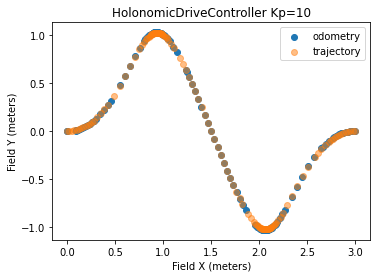

In [9]:
plot_trajectories(holonomic_speeds, odometry_poses, trajectory.states(), Kp)

In [10]:
print(f"trajectory time = {trajectory.totalTime():0.3} sec")
print(f"translation_error_max = {controller.max_translation_error:0.3} meters")
print(
    "translation_error_max position:"
    f" x = {controller.translation_error_max_pos.x:0.3} meters,"
    f" y = {controller.translation_error_max_pos.y:0.3} meters"
)
print(f"x_fb_max = {controller.x_fb_max:0.3} meters/sec")
print(f"y_fb_max = {controller.y_fb_max:0.3} meters/sec")

trajectory time = 6.27 sec
translation_error_max = 0.0813 meters
translation_error_max position: x = 1.96 meters, y = -0.979 meters
x_fb_max = -0.43 meters/sec
y_fb_max = 0.695 meters/sec
